# Adjusting Weighted Average Scoring for a Time-delayed Subnet
We noticed that for our specific subnet with time-delayed incentive, the default alpha-based weighted averaging scoring from Bittensor did not suffice for providing a fair and open mining environment. Therefore we have implemented a slightly adapted version, which we detail and showcase below. Since we are a subnet with time-delayed scoring, we run into the following challenges:
- Since a lot of our challenges are in the future, most of them will not be scored quickly
- We do not want to increase challenge frequency too much, to limit the storage and network requirements for validators (and miners)
- We also do not want an immunity period of more than 24 hours, as this would reduce overall competitiveness in the subnet.

### The default Bittensor solution
By default, the above issues can be remedied through the adjustment $\alpha$. This variable is used to update a running average of the score, using the following formula: $new\_score = (1 - \alpha) * old\_score + \alpha * latest\_score$. Note that the initial score of a subnet is always low (usually 0) to ensure that new miners need to actually proof that they are better than the worst current miner. A nice benefit of this scoring mechanism is that later scores are weighted more than initial ones, favouring innovation.
If we use a high value of $\alpha$, like for example 0.2, we can ensure that even with limited challenges miners' score will rise quickly enough in the short immunity period to not be immediately deregistered.

### The problem
Using $\alpha=0.2$ leads to unfair fluctuations! Even the best of miners can have their emissions fluctuate immensely, because their current score is so dominated by the last prediction. This is especially unfair since the challenge difficulty can vary immensely, comparing an ocean to for example a mountaineous region. Ideally we therefore want a lower $\alpha$, but on its own this would mean new miners cannot reach competitive scores within the immunity period.

## The solution
We introduce an **adaptive** adjustment alpha. This $\alpha$ starts at an initial high value which ensures a well-performing miner's score rises quickly during the immunity period. After the immunity period, this $\alpha$ value steadily scales down to a lower value over a time period of the same length as the immunity period. Therefore, once a miner is outside the immunity period, their score will fluctuate less and less, resulting in a fairer evaluation. 

> This notebook demonstrates this principle, and showcases why the chosen values of certain constants work. In this example we have a score graph for a new miner, which at the end of the immunity period should have a reached a score that is roughly equal to a certain 'common miner score'. We assume that for every **scored** challenge it gets on average this score. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [39]:
ALPHA_MAX = 0.2
ALPHA_MIN = 0.02

NUM_PLOT_DAYS = 3
IMMUNITY_DAYS = 1 # we keep this fixed

# A challenge gets send every 90 seconds, and account for time spend fetching data/scoring - overestimate for safety
CHALLENGE_DELAY_SECONDS = 100

# what the average miner's score looks like
COMMON_MINER_SCORE = 0.85

In [40]:
def make_plot(scored_challenges_per_day, days=NUM_PLOT_DAYS):
    immunity_challenges = scored_challenges_per_day * IMMUNITY_DAYS
    xs = np.arange(scored_challenges_per_day * days)
    ys = [0]
    alphas = []
    for i in xs:
        # During immunity, use alpha high. Next period of immunity length, alpha scales linearly from ALPHA_MAX -> ALPHA_MIN
        # NOTE: in the live code this calculation is based on the number of blocks since registration, but that yields the same effect.
        if i < immunity_challenges:
            alpha = ALPHA_MAX
        elif i < 2 * immunity_challenges:
            scaling = (i - immunity_challenges) / immunity_challenges
            alpha = (1 - scaling) * ALPHA_MAX + scaling * ALPHA_MIN
        else:
            alpha = ALPHA_MIN
            
        alphas.append(alpha)
        ys.append((1- alpha) * ys[-1] + alpha * COMMON_MINER_SCORE)

    plt.hlines(xmin=xs[0], xmax=xs[-1], colors=['r'], y=COMMON_MINER_SCORE, label="normal competition score")
    plt.plot(xs, ys[:-1], label="new miner score")
    plt.plot(xs, alphas, label=r"adjusted $\alpha$")
    plt.vlines(x=scored_challenges_per_day * IMMUNITY_DAYS, ymin=0, ymax=1,  colors=['black'], label="immunity period")
    plt.axis([xs[0], xs[-1], 0, 1])
    plt.ylabel("Score")
    plt.xlabel("Number of scored challenges")
    plt.title(f"Score distribution for {scored_challenges_per_day} scored challenges per day")
    plt.legend(loc=(0.55, 0.2))
    plt.show

## Most common case
On average, miners will get send $\pm$ 35 challenges that are already scored in the first 24 hours (immunity period). Note that they get send much more challenges (half the miners get send a challenge once every $\pm$ 90 seconds), but only challenges with a start and end time before the first 24 hours can be scored within that timeframe.

We found this value by simulating 100,000 samples of a start hour, and calculating the cummulative probability of both the start and the end of the challenge being within the immunity period. This is demonstrated in the cell below. 
It can also be estimated by taking into account the [start-offset distribution](../static/era5_start_offset_distribution.png) and the fact that a challenge duration is uniform between 1 and 24 hours. We also confirmed this value emperically by looking at live miners.

In this common/average case, a new miner easily recovers a competitive/common score well before the immunity period ends, as demonstrated by the plot underneath.

In [37]:
# simulate start_hour samples, following the CDS sampling code
samples = 100000
start_range = (-119, 168)
uniform = np.random.randint(*start_range, size=int(0.1 * samples))
decreasing = np.abs(np.random.normal(0, 35, size=int(0.9 * samples))).astype(int) + start_range[0]
start_total = np.concat((uniform, decreasing))

total_hours = IMMUNITY_DAYS * 24 - 1

def get_prob_scored(offset):
    # calculate total probability that a challenge starts and ends in first 24 hours
    prob_scored_total = 0
    max_length = total_hours - offset
    for hour in range(start_range[0], start_range[0] + max_length):
        prob_start_hour = (start_total == hour).sum() / len(start_total)
        length = max_length - (hour - start_range[0]) # how many hours can we predict while keeping challenge end in immunity period
        prob_scored_total += prob_start_hour * length / 24
    return prob_scored_total

# Half the miners get send each challenge
scored_per_day = 0
challenges_per_hour = int((3600 / CHALLENGE_DELAY_SECONDS) / 2)
for offset in range(0, total_hours):
    scored_per_day += challenges_per_hour * get_prob_scored(offset)

print(f"You are send roughly {challenges_per_hour} challenges per hour")
print(f"Each new miner receives roughly {scored_per_day:.2f} challenges scored within the immunity period")

You are send roughly 18 challenges per hour
Each new miner receives roughly 35.31 challenges scored within the immunity period


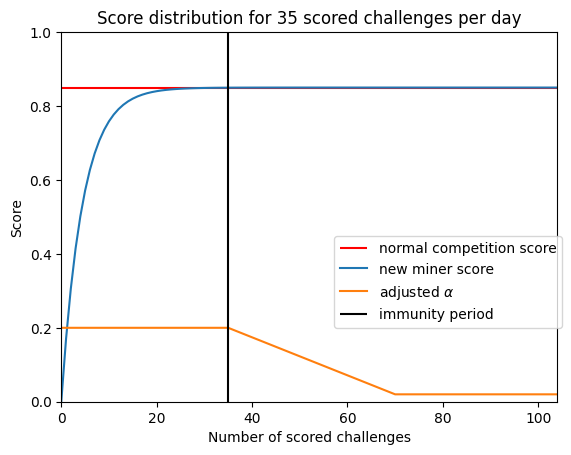

In [41]:
make_plot(scored_challenges_per_day=35)

## Extreme cases
As long as a miner only gets 25 (or more) scored challenges within the immunity period, they can still become competitive as shown below. The chance of getting less than 25 is extremely low. They are just as likely to receive more scored challenges within this timeframe, which will make their score easily competitve within the immunity period. Note also that if their score is only slightly better than the lowest competition score, they will rise quicker too and stay in the competition easily.

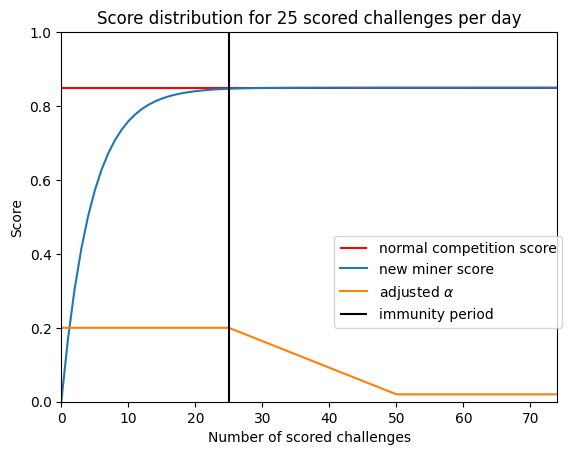

In [42]:
make_plot(scored_challenges_per_day=25)